In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plot
import math
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
max_point = 29
max_point3 = 2
max_point2 = 25

In [4]:
NOISE = 0.2
MEAN_NOISE = 0.0

######################################################
# fix me
# Parameters for CNNs
CNN1_inputchannel = 3
CNN1_outchannel = 4 
CNN1_kernal = 11
CNN1_stride = 1

CNN2_outchannel = 8
CNN2_kernal = 8
CNN2_stride = 1

CNN3_outchannel = 16
CNN3_kernal = 4
CNN3_stride = 1

Pool_kernal = 2 # max pooling
Pool_stride = 2

num_epochs = 30
batch_size = 15

sensor_ref = [0,0]
sensor1 = [10,0]
sensor2 = [0,10]
sensor3 = [10,10]

world_size_x = 10
world_size_y = 10
grid_size = 0.1

epsilon = 0.05
temperature = 0.1
######################################################

MC_N = 10** 4  # Number of total simulation
MC_N = int(MC_N * 2)
size_x = 10   # X axis size
size_y = 10   # Y axis size

In [5]:
def target_moving_detail_random(x_cor_list, y_cor_list, velocity_list, acceleration_list): #측정 시간 단위는 1초로! 속도 단위는 m/s
    x_cor_t_n_1 = x_cor_list[-1]
    y_cor_t_n_1 = y_cor_list[-1]
    velocity = velocity_list[-1]
    acceleration = acceleration_list[-1]
    
    s = velocity * 1        
    direction = 360 * np.random.rand(1)
    
    x_cor_t_n = x_cor_t_n_1 + s * math.cos(direction)
    y_cor_t_n = y_cor_t_n_1 + s * math.sin(direction)
    
    if(x_cor_t_n > 2 or x_cor_t_n < 0):
        x_cor_t_n = y_cor_t_n_1
        
    if(y_cor_t_n > 2 or y_cor_t_n < 0):
        y_cor_t_n = y_cor_t_n_1
        
    
    x_cor_list.append(round(x_cor_t_n,2))
    y_cor_list.append(round(y_cor_t_n,2))   
    
    acceleration = 0.5 * float(np.random.randn(1))
    velocity = velocity + acceleration * 1
    
    if(velocity < 0):
        velocity = 0
        
    elif(velocity>2.2): #인간 평균 걸음 속도는 1.1m/s 이고 뛰는 평균 속도는 5m/s이다
        velocity = 1.1
    
    acceleration_list.append(round(acceleration,2))
    velocity_list.append(round(velocity,2))
    
# 타겟 X(대문자 X) , x좌표 x(소문자 x)    
X_x_list = [1]    # 타겟의 첫 x좌표
X_y_list = [1]    # 타겟의 첫 y좌표 
velocity_list = [1.1]
acceleration_list =[0]   

MC_N = 10** 3  # Number of total simulation
MC_N = MC_N * 2

while(len(X_x_list) < MC_N):
    target_moving_detail_random(X_x_list, X_y_list, velocity_list, acceleration_list)


sensor_ref_x_list = [0] * MC_N                      #sensor ref x coordinate
sensor_ref_y_list = [0] * MC_N                      #sensor ref  y coordinate
sensor_one_x_list = [size_x] * MC_N                 #sensor 1 x coordinate
sensor_one_y_list = [0] * MC_N                      #sensor 1 y coordinate
sensor_two_x_list = [0] * MC_N                      #sensor 2 x coordinate
sensor_two_y_list = [size_y] * MC_N                 #sensor 2 y coordinate
sensor_three_x_list = [size_x] * MC_N                #sensor 3 x coordinate
sensor_three_y_list = [size_y] * MC_N                #sensor 3 y coordinate



df = pd.DataFrame(data = {'X_x':X_x_list , 'X_y' : X_y_list  
                         })

In [6]:
from __future__ import division, print_function
from multilateration_tdoa import TDoAEngine, TDoAMeasurement, Anchor, Point
import numpy as np

def noise():
    """Returns gaussian noise"""
    return np.random.normal(MEAN_NOISE, NOISE)

def tdoa(A,B,P):
    """Computes |PB| - |PA| + gaussian noise"""
    return P.dist(B)-P.dist(A) + noise()

def fakeTDOA(A,B,P):
    """Returns a fake measurements with anchors A, B from a point P"""
    return TDoAMeasurement(A, B, tdoa(A,B,P))

engine = TDoAEngine(n_measurements=6, max_dist_hess=100) # Avoid value rejection.

A = Anchor((0,0,0))
B = Anchor((world_size_x,0,0))
C = Anchor((world_size_x,world_size_y,0))
D = Anchor((0,world_size_y,0))

TDOA_X_hat_ref_one_error_list = [-100] * MC_N  
TDOA_X_hat_ref_two_error_list = [-100] * MC_N  
TDOA_X_hat_ref_three_error_list = [-100] * MC_N  
 

for i in range(MC_N):
    P = Point(X_x_list[i],X_y_list[i],0)
    
    TDOA_X_hat_ref_one_error_list[i] =   float(fakeTDOA(A, B, P).tdoa) # ref과 앵커 B와 TDOA
    TDOA_X_hat_ref_two_error_list[i] =  float(fakeTDOA(A, C, P).tdoa) # ref과 앵커 C와 TDOA
    TDOA_X_hat_ref_three_error_list[i] =   float(fakeTDOA(A, D, P).tdoa)# ref과 앵커 D와 TDOA

df['TDOA_X_hat_ref_one_error'] = TDOA_X_hat_ref_one_error_list
df['TDOA_X_hat_ref_two_error'] = TDOA_X_hat_ref_two_error_list
df['TDOA_X_hat_ref_three_error'] = TDOA_X_hat_ref_three_error_list

df_parsing = df[['TDOA_X_hat_ref_one_error' , 'TDOA_X_hat_ref_two_error' , 'TDOA_X_hat_ref_three_error' , 'X_x' , 'X_y']]
df_parsing.columns = ['TDOA_1', 'TDOA_2', 'TDOA_3' , 'coordinate_x' , 'coordinate_y']

df_parsing = df_parsing.reset_index(drop=True)

TDOA_X_ref_one_list = df_parsing['TDOA_1'].tolist()
TDOA_X_ref_two_list = df_parsing['TDOA_2'].tolist()
TDOA_X_ref_three_list = df_parsing['TDOA_3'].tolist()

TDOA_pair_ref = [(TDOA_X_ref_one_list[ii], TDOA_X_ref_two_list[ii], TDOA_X_ref_three_list[ii]) for ii in range(len(TDOA_X_ref_one_list))]

ylabel_ref = [(X_x_list[ii] / size_x, X_y_list[ii] / size_y ) for ii in range(len(X_x_list))] 

In [7]:
def ScalerCoordinate(value):   #world size = area's width and height , value =  x,y coordinate
    world_size = 10
    value = value / world_size
    return value


def ScalerTDOA(value):   #world size = area's width and height , value = TDOA value
    #world_size = 25 * 2**(0.5)
    world_size = 100  
    value = value / world_size
    return value


df = df_parsing

df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']] = df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].apply(ScalerTDOA)  #길이에 대하여 스케일링
df[['coordinate_x' , 'coordinate_y']] = df[['coordinate_x' , 'coordinate_y']].apply(ScalerCoordinate)  #좌표에 대하여 스케일링

train_df , test_df = train_test_split(df, test_size = 0.2)

train_TDOAs = train_df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].to_numpy()
train_X_Hats = train_df[['coordinate_x' , 'coordinate_y']].to_numpy()

test_TDOAs = test_df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].to_numpy()
test_X_Hats = test_df[['coordinate_x' , 'coordinate_y']].to_numpy()

In [8]:
# TDOA image 생성 모듈 정의
# input: TDPA
# output: TDOA_images
def TDOA_image_generation(sensor1, sensor2, TDOA, world_size_x, world_size_y, grid_size, epsilon, temperature):
   
  center_x = np.linspace(0 , world_size_x , int(world_size_x / grid_size))  + 0.5*grid_size  # x길이 10에 그리드사이즈가 2로 가정했을때 해당 좌표의 중심 좌표는 1, 3, 5, 7, 9 => 이를 수학적으로 수열화 한거!
  center_y = np.linspace(world_size_y , 0 , int(world_size_x / grid_size))  + 0.5*grid_size  # 마찬가지
  cord_center_x, cord_center_y = np.meshgrid(center_x,center_y)  #이를 매트릭스화
  
  distance_matrix = np.sqrt((cord_center_x - sensor1[0])**2 + (cord_center_y - sensor1[1])**2) - np.sqrt((cord_center_x - sensor2[0])**2 + (cord_center_y - sensor2[1])**2)  # 그리드 사이즈 중심좌표로부터 센서간의 거리의 계산 차 (=중심 좌표의 TDOA)
  tdoa_distance = np.abs(distance_matrix - TDOA)  #실제 TDOA 값과 차이 계산

  # 예시 [[10.8,0.38]
  #        [7.679,12.6479]]

  lfunc = lambda x: np.round(1 / (1 + np.exp( (x - epsilon) / temperature)), 5)
  tdoa_image = lfunc(tdoa_distance)

  return tdoa_image

In [9]:
TDOA_sample = TDOA_pair_ref[0][0]
TDOA_sample_image = TDOA_image_generation(sensor_ref, sensor1, TDOA_sample, world_size_x, world_size_y, grid_size, epsilon, temperature)
TDOA_sample_image.shape

(100, 100)

In [10]:
TDOA_images_ref = []
for ii in range(len(TDOA_pair_ref)):
    image1 = TDOA_image_generation(sensor_ref, sensor1, TDOA_pair_ref[ii][0], world_size_x, world_size_y, grid_size, epsilon, temperature)
    image2 = TDOA_image_generation(sensor_ref, sensor2, TDOA_pair_ref[ii][1], world_size_x, world_size_y, grid_size, epsilon, temperature)
    image3 = TDOA_image_generation(sensor_ref, sensor3, TDOA_pair_ref[ii][2], world_size_x, world_size_y, grid_size, epsilon, temperature)
    TDOA_images_ref.append((image1, image2, image3))
    if(len(TDOA_images_ref) % 1000 == 0):
      print(len(TDOA_images_ref))

1000
2000


In [11]:
TDOA_images_cnn = TDOA_images_ref
ylabels = ylabel_ref

TDOA_images_test = TDOA_images_cnn[int(0.8*MC_N):]
TDOA_image_val = TDOA_images_cnn[int(0.6*MC_N):int(0.8*MC_N)]
TDOA_image_train = TDOA_images_cnn[:int(0.6*MC_N)]

ylabels_test = ylabels[int(0.8*MC_N):]
ylabels_val = ylabels[int(0.6*MC_N):int(0.8*MC_N)]
ylabels_train = ylabels[:int(0.6*MC_N)]

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_cnn():
    model = keras.Sequential()

    model.add(layers.Conv2D(CNN1_outchannel, (CNN1_kernal, CNN1_kernal), activation=layers.LeakyReLU(alpha=0.01), strides=CNN1_stride, 
                            input_shape= (TDOA_sample_image.shape[0],TDOA_sample_image.shape[1], CNN1_inputchannel) ,kernel_initializer='he_normal'))
    model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides= (Pool_stride, Pool_stride), padding = "SAME"  ) )
    model.add(layers.Conv2D(CNN2_outchannel, (CNN2_kernal, CNN2_kernal),  activation=layers.LeakyReLU(alpha=0.01), strides=CNN2_stride ,kernel_initializer='he_normal'))
    model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides=  (Pool_stride, Pool_stride), padding = "SAME"))
    model.add(layers.Dropout(0.6))
    model.add(layers.Conv2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal), activation=layers.LeakyReLU(alpha=0.01), strides=CNN3_stride ,kernel_initializer='he_normal'))
    model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides=  (Pool_stride, Pool_stride), padding = "SAME"))
    model.add(layers.Conv2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal), activation=layers.LeakyReLU(alpha=0.01), strides=CNN3_stride ,kernel_initializer='he_normal')) 
    model.add(layers.BatchNormalization()) 
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(2, activation=None))
    return model

model = create_cnn()

In [13]:
model.compile(optimizer=Adam(learning_rate=1 * 1e-3),
        loss='MSE',
        metrics=['mse'])


model.load_weights("MultilaterationTDOA/실험모음/weight/cnn/cp-" + str(max_point+1) + ".ckpt")

predict_X_Hats = model.predict(np.array(TDOA_images_cnn).swapaxes(1,3))

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*world_size_x - np.array(ylabels)*world_size_x), axis = 1))

mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

평균 오차 거리 :  0.9517 미터


In [14]:
# Do not modify this block
from tensorflow.keras import models
from tensorflow.keras import layers

def create_fcnn():
    model2 = models.Sequential()
    model2.add(layers.Dense(32, activation='relu', input_shape=(3,)))
    model2.add(layers.Dropout(0.4))
    model2.add(layers.Dense(16, activation='relu'))
    model2.add(layers.Dense(8, activation='relu'))
    model2.add(layers.Dense(2))
    model2.compile(optimizer=Adam(learning_rate=1 * 1e-3), loss='mse', metrics=['mse'])
    return model2

model2 = create_fcnn()

model2.load_weights("MultilaterationTDOA/실험모음/weight/fcnn/cp-0" + str(max_point3+1) + ".ckpt")
  
predict_X_Hats = model2.predict(df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].to_numpy())

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*world_size_x - df[['coordinate_x' , 'coordinate_y']].to_numpy()*world_size_x), axis = 1))

mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

predict_X_Hats2 = predict_X_Hats

평균 오차 거리 :  1.055 미터


In [15]:
lstm_time_series = 4

TDOA_images_ref_temp = np.array(TDOA_images_ref)

for i in range(lstm_time_series):
    globals()['TDOA_imgaes_lstm{}'.format(i)] = TDOA_images_ref_temp[i:int(MC_N-lstm_time_series+i+1)]

TDOA_images_lstm = np.stack(  [TDOA_imgaes_lstm0 , TDOA_imgaes_lstm1,TDOA_imgaes_lstm2,TDOA_imgaes_lstm3] ,axis=1 )

ylabels = np.array(ylabels)

for i in range(lstm_time_series):
    globals()['ylabels_lstm{}'.format(i)] = ylabels[i:int(MC_N-lstm_time_series+i+1)]

ylabels_lstm = np.stack(  [ylabels_lstm0, ylabels_lstm1, ylabels_lstm2, ylabels_lstm3] ,axis=1 )

ylabels_lstm = ylabels[lstm_time_series-1:]

In [16]:
TDOA_images_lstm.shape

(1997, 4, 3, 100, 100)

In [17]:
ylabels_lstm.shape

(1997, 2)

In [18]:
from tensorflow.keras.utils import plot_model

def create_conv_lstm():
    seq = keras.Sequential()
    seq.add(layers.ConvLSTM2D(CNN1_outchannel, (CNN1_kernal, CNN1_kernal),
                            input_shape= (4, TDOA_sample_image.shape[0],TDOA_sample_image.shape[1], CNN1_inputchannel ) ,return_sequences=True))
    seq.add(layers.MaxPool3D(pool_size=(Pool_kernal,Pool_kernal,Pool_kernal), strides= (1,Pool_stride, Pool_stride), padding = "SAME"))
    seq.add(layers.ConvLSTM2D(CNN2_outchannel, (CNN2_kernal, CNN2_kernal),return_sequences=True))
    seq.add(layers.MaxPool3D(pool_size=(Pool_kernal,Pool_kernal,Pool_kernal), strides=  (1,Pool_stride, Pool_stride), padding = "SAME"))
    seq.add(layers.Dropout(0.6))
    seq.add(layers.ConvLSTM2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal),return_sequences=True))
    seq.add(layers.MaxPool3D(pool_size=(Pool_kernal,Pool_kernal,Pool_kernal), strides=  (1,Pool_stride, Pool_stride), padding = "SAME"))
    seq.add(layers.ConvLSTM2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal),return_sequences=False))
    seq.add(layers.BatchNormalization()) 
    seq.add(layers.Flatten())
    seq.add(layers.Dense(128, activation='relu'))
    seq.add(layers.Dropout(0.5))
    seq.add(layers.Dense(32, activation='relu'))
    seq.add(layers.Dense(2, activation=None))
    return seq



seq = create_conv_lstm()
seq.load_weights(
        "MultilaterationTDOA/실험모음/weight/conv_cnn/cp-" + str(max_point2+1) + ".ckpt"
    )

predict_X_Hats = seq.predict(TDOA_images_lstm.swapaxes(2,4))

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*world_size_x - ylabels_lstm*world_size_x), axis = 1))

mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

평균 오차 거리 :  0.4375 미터


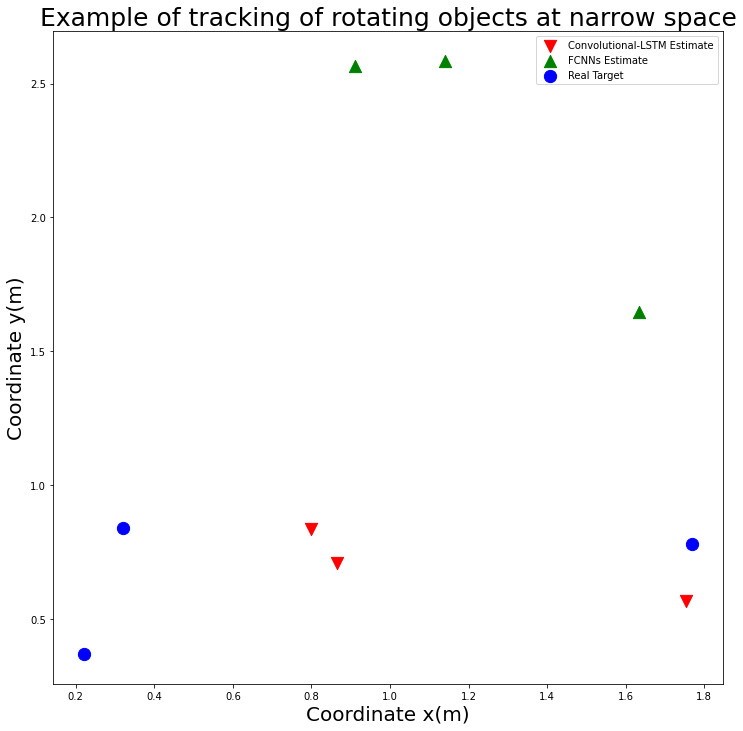

In [19]:
conv_lstm_temp_x = []
conv_lstm_temp_y = []
fcnn_temp_x = []
fcnn_temp_y = []

real_label_x = []
real_label_y = []

for i in range(len(ylabels_lstm)):
    if i % 800 == 0:
        conv_lstm_temp_x.append(predict_X_Hats[i][0]*world_size_x)
        conv_lstm_temp_y.append(predict_X_Hats[i][1]*world_size_x)
        
        fcnn_temp_x.append(predict_X_Hats2[i][0]*world_size_x)
        fcnn_temp_y.append(predict_X_Hats2[i][1]*world_size_x)
        
        real_label_x.append(ylabels_lstm[i][0]*world_size_x)
        real_label_y.append(ylabels_lstm[i][1]*world_size_x)
        
        import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
#plt.plot(X_x_list, X_y_list)
plt.scatter(conv_lstm_temp_x,conv_lstm_temp_y,marker="v",color='r',label="Convolutional-LSTM Estimate", s=150)
plt.scatter(fcnn_temp_x,fcnn_temp_y,marker="^",color='g',label="FCNNs Estimate", s=150)
plt.scatter(real_label_x,real_label_y,marker="o",color='b',label="Real Target", s=150)
plt.xlabel('Coordinate x(m)', fontsize=20)
plt.ylabel('Coordinate y(m)', fontsize=20)
plt.title('Example of tracking of rotating objects at narrow space', fontsize=25)
plt.legend()
plt.savefig('random_whole_example')
plt.show()



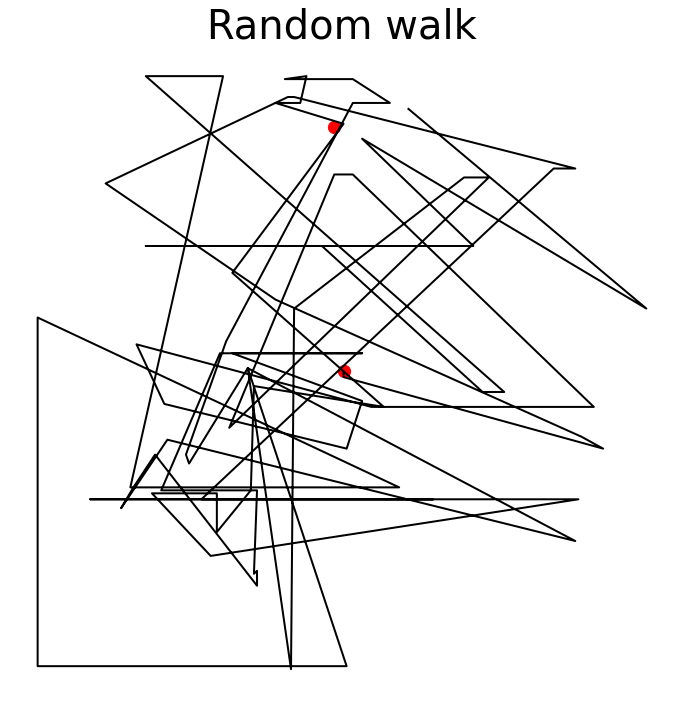

In [21]:
plt.figure(figsize=(12,12))
plt.plot(X_x_list[:100], X_y_list[:100], linewidth = 2, color='black')
plt.scatter(X_x_list[100],X_y_list[100],marker="o",color='red', s=150)
plt.scatter(X_x_list[0],X_y_list[0],marker="o",color='red', s=150)
plt.title('Random walk',fontsize=40)
plt.axis('off')
plt.savefig('random')